# An Introduction to Neural Networks: Learning and Controlling the Dubins car

Our goal is to **learn a non-linear dynamics and control it to fulfill a certain objective using fully connected neural networks**. We will employ the Pytorch library, which is an optimized tensor library for deep learning using GPUs and CPUs (https://pytorch.org/).

The non-linear dynamics explored in this assignment is the (discrete-time) Dubins Car, which represents a simplified model of a vehicle. Let $\tau$ be a step size, $v_t$ the vehicle's heading velocity, $\omega_t$ a control of its steering angle. The Dubins car model can be described as:

\begin{equation}
x_{t+1} = f(x_t, u_t) = \begin{bmatrix}
                      x_{t}^{(1)} + \tau v_t \sin(x_{t}^{(3)}) \\
                      x_{t}^{(2)} + \tau v_t \cos(x_{t}^{(3)}) \\
                      x_{t}^{(3)} + \tau \omega_t
                    \end{bmatrix}
\end{equation}

where $x_{t}^{(1)}$ represents the $x$-position of the car at instant $t$, $x_{t}^{(2)}$ the $y$-position, and $x_{t}^{(3)}$ is its steering angle, and $u_t = (v_t, \omega_t)$ is the control input.

### Instructions

- **Follow instructions throughout the code**: Your tasks are marked as TODOs in the code.

- **Please send us your notebook (.ipynb) containing all the results (WE WON'T RUN YOUR NOTEBOOK)**. We won't open any other supplementary file.

### Preliminaries

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from regions import HyperRectangle
from plotting import plot_environment

from dynamics import DubinsCar
from dataset import Dataset
from neural_network import Neural_Network_Dynamics

torch.manual_seed(0)

##### Constructing the environment

We will consider a safe environment given by the set xxx, except for an obstacle given by xxx. We will also consider a target in xxx. Later in this notebook, our goal will be to design a controller which keeps the vehicle in the safe set, while avoiding the obstacle, and eventually reaching the target.

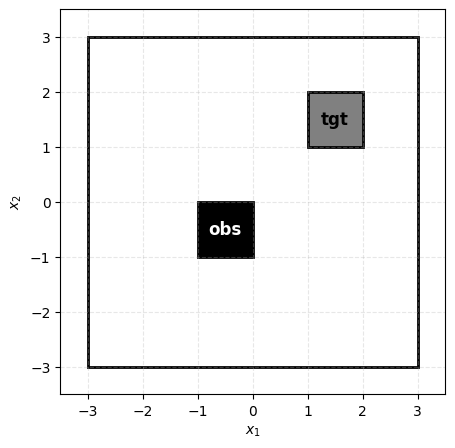

In [2]:
# Set environment
safe_set = HyperRectangle(torch.tensor([-3.0, -3.0, -2 * math.pi]), torch.tensor([3.0, 3.0, 2 * math.pi]))
obstacle = HyperRectangle(torch.tensor([-1.0, -1.0, -2 * math.pi]), torch.tensor([0.0, 0.0, 2 * math.pi]))
target = HyperRectangle(torch.tensor([1.0, 1.0, -2 * math.pi]), torch.tensor([2.0, 2.0, 2 * math.pi]))
control_support = HyperRectangle(torch.tensor([-1.0, -0.4]), torch.tensor([1.0, 0.4]))

##### Generating data

To build our dataset, we will randomly select initial states $x$ and control inputs $u=(v, \omega)$ and call the oracle to build a data pair $((x, u), x^{+})$, where $x^{+}$ is the next state given by the underlying dynamics. We will store all those data pairs as a dataset $\mathcal{D} = \{ (x_{n}, u_{n}), x_{n+1}  \}_{n=0}^{N}$.

PS: *Feel free to store this dataset on a separate structure (e.g. a CSV) if you want to prevent regenerating data each time you launch the notebook.*

In [3]:
# Generate dataset
N = 10000
oracle = DubinsCar(tau=0.1)
dataset = Dataset(dynamics=oracle, state_support=safe_set, control_support=control_support, dataset_size=N)

Note that the *Dataset* class has a field *extended_input* storing a tensor (N, 5) representing the N observations of (x, u), and a field *output* storing a tensor (N, 3) representing the N observations of the next state given by the underlying dynamics.

In [4]:
X = dataset.data.extended_input # (N, 5)
y = dataset.data.output # (N, 3)

#### Splitting the dataset into training and testing sets

Create tensors X_train and y_train by randomly selecting 70% of the respective observations in X and y. The tensors X_test and y_test will contain the remaining data pairs.



In [5]:
# Split X and y into train and test data
N_train = int(0.7 * N)
perm = torch.randperm(N)

# Split indices
train_idx = perm[:N_train]
test_idx = perm[N_train:]

# Split data
X_train, y_train = X[train_idx], y[train_idx] # TODO: Create train tensors
X_test, y_test = X[test_idx], y[test_idx] # TODO: Create test tensors

### Building our first (simple and small) neural network
The goal is now to create a **dense feedforward neural network** (hereafter denoted by $f_{\text{NN}}$) which will try to learn the dynamics. In other words, we would like that, for any state $x$ and control input $u$, $f_{\text{NN}}(x, u) \approx f(x, u)$ (where $f$ represents the the true underlying dynamics).


In [6]:
net = Neural_Network_Dynamics() # TODO: Implement the class Neural_Network_Dynamics in the file neural_network.py

#### Training the neural network
The weights of our NN are initialized to random values. It is our duty to train this network (i.e. optimize those weights) so that our NN model is capable to correctly predict the behavior of the dynamics. Here, we have to do a number of steps.

##### Select an appropriate loss function

You can consult, for instance: https://docs.pytorch.org/docs/stable/nn.html#loss-functions

In [7]:
loss_func = nn.MSELoss() # TODO: Initialize appropriate loss function for the problem

##### Define an optimizer for the gradient descent
Gradient descent is usually the optimization technique used to minimize the loss. Once we have computed the gradient of the loss $L$ with respect to the weights $w$, there are several ways in which we can update $w$. Pytorch offers various optimizer algorithms for such a task  (https://pytorch.org/docs/stable/optim.html). This paper (https://arxiv.org/pdf/1412.6980.pdf) introduces the Adam algorithm, which we suggest as an initial try.


In [8]:
optimizer = optim.Adam(net.parameters(), lr = 0.001, betas = (0.9, 0.999)) # TODO: Initialize the optimizer

##### Train the neural network

In [9]:
net.train() # set network to training mode


Neural_Network_Dynamics(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

In [10]:
# TODO: Write your own training loop
epochs = 100 # how many times we want to go through the whole data set
batch_size = 16 # how many samples do we process before updating weights

n_samples = y_train.size(0)
batches = n_samples // batch_size # how many batches are there when dividing the whole data set

for epoch in range(1, epochs + 1):
    indices = torch.randperm(n_samples)

    loss_epoch = 0

    for b in range(batches):
        idx_batch = indices[b * batch_size:(b + 1) * batch_size]
        X_batch = X_train[idx_batch] # Get respective input data
        y_batch = y_train[idx_batch] # Get respective output data

        # delete gradients from optimizer (otherwise, gradients are cumulative summed up over all previous batches)
        optimizer.zero_grad()
        # predict the output for the given inputs (forward pass)
        y_batch_pred = net(X_batch)
        # calculate the loss of the predicted input (forward pass)
        loss = loss_func(y_batch_pred, y_batch)
        # get the gradients of the trainable paramters for the given loss (backward pass)
        loss.backward()
        # apply the gradients and change weights
        optimizer.step()

        loss_epoch += loss.item()

    loss_epoch /= batches
    print('Loss for epoch {}/{}: {:0.4e}'.format(epoch,epochs, loss_epoch) )

Loss for epoch 1/100: 4.7493e+00
Loss for epoch 2/100: 1.2301e+00
Loss for epoch 3/100: 1.0383e+00
Loss for epoch 4/100: 9.6850e-01
Loss for epoch 5/100: 9.3956e-01
Loss for epoch 6/100: 9.2114e-01
Loss for epoch 7/100: 9.0344e-01
Loss for epoch 8/100: 8.8050e-01
Loss for epoch 9/100: 8.3062e-01
Loss for epoch 10/100: 7.4287e-01
Loss for epoch 11/100: 6.5212e-01
Loss for epoch 12/100: 5.6405e-01
Loss for epoch 13/100: 4.8340e-01
Loss for epoch 14/100: 4.1184e-01
Loss for epoch 15/100: 3.5204e-01
Loss for epoch 16/100: 3.0279e-01
Loss for epoch 17/100: 2.6342e-01
Loss for epoch 18/100: 2.3247e-01
Loss for epoch 19/100: 2.0776e-01
Loss for epoch 20/100: 1.8906e-01
Loss for epoch 21/100: 1.7473e-01
Loss for epoch 22/100: 1.6281e-01
Loss for epoch 23/100: 1.5286e-01
Loss for epoch 24/100: 1.4529e-01
Loss for epoch 25/100: 1.3884e-01
Loss for epoch 26/100: 1.3300e-01
Loss for epoch 27/100: 1.2881e-01
Loss for epoch 28/100: 1.2450e-01
Loss for epoch 29/100: 1.2028e-01
Loss for epoch 30/100: 

In [ ]:
# TODO: Plot the training loss curve (i.e. the number of epochs in the x-axis and the loss in the y-axis)

### Testing the model
Finally, let's test the model in the testing set and compare with the loss we obtained in the training set.

In [11]:
net.eval() # Set model to evaluation mode
with torch.no_grad(): # Only build forwards graph => faster method
    y_test_pred = net(X_test)

loss_test = loss_func(y_test, y_test_pred) # TODO: Compute loss between y_test_pred and y_test
print('Loss on testing set:', loss_test)

# TODO: Compare the testing loss with the training loss

Loss on testing set: tensor(0.0851)


### Visualizing predictions from the NN

Given the initial state $x_0$ and the control sequence $u_t$ defined below, plot the position coordinates $x^{(1)}_t$ and $x^{(2)}_t$ of the vehicle for each time step and compare with the trajectory you would obtain using the oracle.

In [13]:
x_0 = torch.tensor([-2.5, -2.5, 0.0])
u_sequence = torch.tensor([[1.0, 0.1], [1.0, 0.1], [1.0, 0.1], [1.0, 0.1], [1.0, 0.1], [1.0, 0.1]])
trajectory = torch.tensor([x_0])

x = x_0
for u in u_sequence:
    x =

### Bonus: Learning a controller

In [ ]:
plot_environment(safe_set, obstacle, target)